In [72]:
from nilearn.glm.first_level import first_level_from_bids
from bids import BIDSLayout
import os
from warnings import warn
from nilearn.glm.first_level.first_level import _get_processed_imgs, _check_bids_image_list, _make_bids_files_filter, infer_slice_timing_start_time_from_dataset
from nilearn.interfaces.bids.utils import bids_entities
from nilearn.interfaces.bids.query import get_bids_files,_get_metadata_from_bids

import numpy as np
import nibabel as nib
import pandas as pd
from pathlib import Path
from nilearn.interfaces.bids import save_glm_to_bids
from nilearn.glm.first_level import make_first_level_design_matrix

In [73]:
bids_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/"
task_label = "nbk"
space_label = "fsLR"
derivatives_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep"
img_filters= [
    # ('run','1'),
    ('ses','01') # Need to add a condition for ses-01 and ses-02 default all
] 
img_filters = []

In [75]:
layout = BIDSLayout(bids_dir, is_derivative=True, validate=False)
# print(type(layout))

ValueError: 'is_derivative' is not a recognized entity. If you're sure you want to impose this constraint, set invalid_filters='allow'.

In [ ]:
layout

BIDS Layout: ..._pipelines_scc/data/local/bids | Subjects: 4 | Sessions: 8 | Runs: 5

In [172]:
for method in dir(layout):
    if callable(getattr(layout, method)) and not method.startswith("__"):
        print(f"{method}: {getattr(layout, method).__doc__}\n")

(return_type='object', target=None, scope='all', regex_search=False, absolute_paths=None, invalid_filters='error', **filters)
_build_file_query: None

_get_derivative_dirs: None

_get_fieldmaps: None

_get_layouts_in_scope: Return all layouts in the passed scope.

_in_scope: Determine whether current BIDSLayout is in the passed scope.

        Parameters
        ----------
        scope : str or list
            The intended scope(s). Each value must be one of 'all', 'raw',
            'derivatives', or a pipeline name.
        

_sanitize_query_dtypes: Automatically convert entity query values to correct dtypes.

add_derivatives: Add BIDS-Derivatives datasets to tracking.

        Parameters
        ----------
        path : str or list
            One or more paths to BIDS-Derivatives datasets.
            Each path can point to either a derivatives/ directory
            containing one or more pipeline directories, or to a single
            pipeline directory (e.g., derivatives/fmr

In [5]:
layout.get(target='subject', return_type='id')

['CMHWM027', 'CMHWM029', 'CMHWM030', 'CMHWM033']

In [177]:
participant_labels = "sub-CMHWM029"

In [5]:
from nilearn.glm.first_level import first_level_from_bids
from bids import BIDSLayout
import os
from warnings import warn
# from nilearn.glm.first_level.first_level import _get_processed_imgs, _check_bids_image_list, _make_bids_files_filter, infer_slice_timing_start_time_from_dataset
# from nilearn.interfaces.bids.utils import bids_entities
# from nilearn.interfaces.bids.query import get_bids_files,_get_metadata_from_bids

class BIDSDataValidator:
    def __init__(self, bids_dir, task_label):
        self.bids_dir = bids_dir
        self.task_label = task_label
        self.layout = BIDSLayout(bids_dir, is_derivative=True, validate=False)
    
    def match_bold_and_events(self, participant_labels=None):
        """

        Check if BOLD and events files match for each participant.

        Args.
            participant_albel (list, optional): List of participant IDs to check.
                                                Default to all participants in the dataset
        Returns:
            dict: participants | session | run.
        """
        

        if not participant_labels:
            participant_labels = self.layout.get_subjects()
            print(f"Retrieved subjects: {participant_labels}")
        elif isinstance(participant_labels, str):
            participant_labels = [participant_labels]
        valid_participants = {}
        
        for sub in participant_labels:
            sub_imgs = self.layout.get(extension='nii.gz', task=self.task_label, subject=sub)
            sub_events_files = self.layout.get(extension='tsv', task=self.task_label, subject=sub)
            valid_sessions = []
            if not img_filters:
                # Iterate over each session for the subject
                for session in layout.get_sessions(subject=sub):
                    print(f" Processing | {sub} | session {session}")
                    # Get the functional images and event files for the specific session
                    session_func_images = [f for f in sub_imgs if f.entities['session'] == session]
                    session_event_files = [e for e in sub_events_files if e.entities['session'] == session]
                    # Check for each run, match the functional image with the event file
                    for run in range(1, len(session_func_images) + 1):
                        matching_img = next((img for img in session_func_images if f'run-{run}' in img.filename), None)
                        matching_event = next((event for event in session_event_files if f'run-{run}' in event.filename), None)
                        if matching_img and matching_event:
                            print(f"Found matching files for run-{run}: {matching_img.filename} and {matching_event.filename}")
                            session = 'ses-' + session
                            run = 'run-' + str(run) 
                            valid_sessions.append((session,run))
                        else:
                            print(f"{sub} has MISSING either BOLD nii or task events files for run-{run} in session {session}. Skipping session.")

            # If the subject has valid sessions, store it in valid_participants
            if valid_sessions:
                valid_participants[sub] = valid_sessions

        return valid_participants

In [158]:
def process_and_fit_glm_model(model, imgs, events, confounds, session, run):
    
    events_df = events[0]
    events_df_tmp = events_df.drop(columns=["correct_response","participant_response","response_time","block"])
    # Filter rows where "trial_type" contains "onebackblock" or "threebackblock"
    events_df_final = events_df_tmp[events_df["trial_type"].str.contains("onebackblock|threebackblock", regex=True)]
    # Confound regressors
    confounds_df = confounds[0][["global_signal","csf","white_matter","rot_x", "rot_y", "rot_z"]]
    
    for col in confounds_df.columns:
            confounds_df.loc[:,col] = confounds_df[col].sub(
            confounds_df[col].mean())
    func_imgs = nib.load(imgs[0])
    n_scans = func_imgs.shape[-1]
    frame_times = np.arange(n_scans)*model.t_r
    
    # design matrix input
    drift_model = 'polynomial'
    drift_order = 5
    hrf_model = 'spm + derivative + dispersion'

    dm = make_first_level_design_matrix(frame_times,events_df_final,drift_model=drift_model,
                                            drift_order=drift_order,
                                            add_regs=confounds_df,
                                            add_reg_names=list(confounds_df.columns),
                                            hrf_model=hrf_model
                                        )
    first_lvl_glm = model.fit(imgs,design_matrices=dm)

    # Writing outputs from the fitted model

    output_dir = Path.cwd() / "results" / "plot_bids_features"
    output_dir.mkdir(exist_ok=True, parents=True)

    
    # # Join key-value pairs into a single formatted string
    save_glm_to_bids(
        model,
        contrasts="threebackblock - onebackblock",
        contrast_types={"threebackblock - onebackblock": "t"},
        out_dir=output_dir / "derivatives" / "nilearn_glm_v2" / f"sub-{model.subject_label}",
        prefix=f"{model.subject_label}_{session}_task-{task_label}_{run}",
    )

In [ ]:
img_filters=[]
is_valid_participants = BIDSDataValidator(bids_dir,task_label)
valid_participants = is_valid_participants.match_bold_and_events(participant_labels="")

Retrieved subjects: ['CMHWM027', 'CMHWM029', 'CMHWM030', 'CMHWM033']
 Processing | CMHWM027 | session 01
CMHWM027 has MISSING either BOLD nii or task events files for run-1 in session 01. Skipping session.
Found matching files for run-2: sub-CMHWM027_ses-01_task-nbk_run-2_bold.nii.gz and sub-CMHWM027_ses-01_task-nbk_run-2_events.tsv
 Processing | CMHWM027 | session 02
Found matching files for run-1: sub-CMHWM027_ses-02_task-nbk_run-1_bold.nii.gz and sub-CMHWM027_ses-02_task-nbk_run-1_events.tsv
 Processing | CMHWM029 | session 01
Found matching files for run-1: sub-CMHWM029_ses-01_task-nbk_run-1_bold.nii.gz and sub-CMHWM029_ses-01_task-nbk_run-1_events.tsv
 Processing | CMHWM029 | session 02
Found matching files for run-1: sub-CMHWM029_ses-02_task-nbk_run-1_bold.nii.gz and sub-CMHWM029_ses-02_task-nbk_run-1_events.tsv
 Processing | CMHWM030 | session 01
Found matching files for run-1: sub-CMHWM030_ses-01_task-nbk_run-1_bold.nii.gz and sub-CMHWM030_ses-01_task-nbk_run-1_events.tsv
 Proc

In [157]:
bids_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/"
task_label = "nbk"
space_label = "fsLR"
derivatives_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep"
# img_filters= [
#     ('run','1'),
#     ('ses','01'),
#     # ('ses','02')
#      # Need to add a condition for ses-01 and ses-02 default all
# ] 

# Loop through valid_participants to construct the img_filters
for participant in valid_participants:
    
    for session, run in valid_participants[participant]:
        img_filters = []
        img_filters.append(('ses', session.split('-')[1]))  # Extract session (e.g., '01')
        img_filters.append(('run', run.split('-')[1]))  # Extract run (e.g., '1')

        print(f"Loading models for subject: {participant} | {session} | {run}")
        models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
            bids_dir,
            task_label,
            space_label,
            sub_labels=[participant],
            derivatives_folder=derivatives_dir,
            img_filters=img_filters,
            drift_model='polynomial',
            drift_order=5,
            hrf_model='spm + derivative + dispersion',
            n_jobs=2,
            mask_img=False,
            minimize_memory=False,
        )
        print(f"Models loaded successfully! {participant}  {session} | {run}")
        print(f"Fitting Models {participant} | {session} | {run}")
        print(f"\n{'='*40}")
        
        for model, imgs, events, confounds in zip(models, models_run_imgs, models_events, models_confounds):
            process_and_fit_glm_model(model, imgs, events, confounds, session, run)

        

        

    
    


Loading models for subject: CMHWM027 | ses-01 | run-2
Models loaded successfully! CMHWM027  ses-01 | run-2
Fitting Models CMHWM027 | ses-01 | run-2



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-01/func/sub-CMHWM027_ses-01_task-nbk_run-2_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Loading models for subject: CMHWM027 | ses-02 | run-1
Models loaded successfully! CMHWM027  ses-02 | run-1
Fitting Models CMHWM027 | ses-02 | run-1



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-02/func/sub-CMHWM027_ses-02_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Loading models for subject: CMHWM029 | ses-01 | run-1
Models loaded successfully! CMHWM029  ses-01 | run-1
Fitting Models CMHWM029 | ses-01 | run-1



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-01/func/sub-CMHWM027_ses-01_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Loading models for subject: CMHWM029 | ses-02 | run-1
Models loaded successfully! CMHWM029  ses-02 | run-1
Fitting Models CMHWM029 | ses-02 | run-1



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-02/func/sub-CMHWM027_ses-02_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Loading models for subject: CMHWM030 | ses-01 | run-1
Models loaded successfully! CMHWM030  ses-01 | run-1
Fitting Models CMHWM030 | ses-01 | run-1



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-01/func/sub-CMHWM027_ses-01_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Loading models for subject: CMHWM030 | ses-02 | run-1
Models loaded successfully! CMHWM030  ses-02 | run-1
Fitting Models CMHWM030 | ses-02 | run-1



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-02/func/sub-CMHWM027_ses-02_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Loading models for subject: CMHWM033 | ses-01 | run-1
Models loaded successfully! CMHWM033  ses-01 | run-1
Fitting Models CMHWM033 | ses-01 | run-1



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-01/func/sub-CMHWM027_ses-01_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Loading models for subject: CMHWM033 | ses-02 | run-1
Models loaded successfully! CMHWM033  ses-02 | run-1
Fitting Models CMHWM033 | ses-02 | run-1



/tmp/ipykernel_3919745/548680216.py:21: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep/sub-CMHWM027/ses-02/func/sub-CMHWM027_ses-02_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
/home/ttan/.pyenv/versions/3.10.7/envs/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:585: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


In [28]:
# z_map = model.compute_contrast("StopSuccess - Go")
import numpy as np
import nibabel as nb
import pandas as pd
from pathlib import Path

from nilearn.plotting import plot_contrast_matrix
file = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-01_task-nbk_run-2_design.tsv'
dm = pd.read_csv(file, delimiter="\t")
dm_df = dm.iloc[4:].reset_index(drop=True)
# plot_contrast_matrix("threebackblock - onebackblock",design_matrix = dm_df)

In [7]:
dm

,onebackblock,onebackblock_derivative,onebackblock_dispersion,threebackblock,threebackblock_derivative,threebackblock_dispersion,global_signal,csf,white_matter,rot_x,rot_y,rot_z,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0,0.000000,0.000000,-1.760050e-18,0.0,0.0,-2.692344e-18,1545.451859,798.588111,1375.178822,-0.001573,-0.002082,0.000796,-0.500000,0.166269,-0.049643,0.014082,-0.003874,1.0
1,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-67.798236,-30.560686,-101.995628,-0.001104,-0.002668,0.003616,-0.497613,0.163888,-0.048221,0.013410,-0.003597,1.0
2,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-15.762900,-22.436950,-37.761497,-0.001322,-0.002206,0.002789,-0.495227,0.161518,-0.046816,0.012752,-0.003329,1.0
3,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-50.527567,-29.308088,-65.137604,-0.001335,-0.002221,0.003101,-0.492840,0.159160,-0.045428,0.012109,-0.003070,1.0
4,0.000646,0.002774,-3.259201e-03,0.0,0.0,0.000000e+00,-46.767329,-29.201040,-65.718502,-0.001412,-0.002318,0.002927,-0.490453,0.156813,-0.044057,0.011480,-0.002820,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-9.802919,-0.969190,5.783344,-0.000157,0.000486,0.000520,0.490453,0.156813,0.044057,0.011480,0.002820,1.0
416,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-6.948233,-0.953169,-4.569091,0.000262,0.000404,0.000466,0.492840,0.159160,0.045428,0.012109,0.003070,1.0
417,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-6.178489,-4.702311,-3.359097,0.000177,0.000071,0.000466,0.495227,0.161518,0.046816,0.012752,0.003329,1.0
418,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-6.206166,-5.782239,-4.428947,0.000368,0.000154,0.000466,0.497613,0.163888,0.048221,0.013410,0.003597,1.0


In [6]:
plt.plot(dm['onebackblock'])

AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

<Figure size 960x720 with 1 Axes>

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.show()
plt.plot(dm[['onebackblock','threebackblock']])

AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

<Figure size 960x720 with 1 Axes>

In [177]:
dm

,onebackblock,onebackblock_derivative,onebackblock_dispersion,threebackblock,threebackblock_derivative,threebackblock_dispersion,global_signal,csf,white_matter,rot_x,rot_y,rot_z,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0,0.000000,0.000000,-1.760050e-18,0.0,0.0,-2.692344e-18,1545.451859,798.588111,1375.178822,-0.001573,-0.002082,0.000796,-0.500000,0.166269,-0.049643,0.014082,-0.003874,1.0
1,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-67.798236,-30.560686,-101.995628,-0.001104,-0.002668,0.003616,-0.497613,0.163888,-0.048221,0.013410,-0.003597,1.0
2,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-15.762900,-22.436950,-37.761497,-0.001322,-0.002206,0.002789,-0.495227,0.161518,-0.046816,0.012752,-0.003329,1.0
3,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-50.527567,-29.308088,-65.137604,-0.001335,-0.002221,0.003101,-0.492840,0.159160,-0.045428,0.012109,-0.003070,1.0
4,0.000646,0.002774,-3.259201e-03,0.0,0.0,0.000000e+00,-46.767329,-29.201040,-65.718502,-0.001412,-0.002318,0.002927,-0.490453,0.156813,-0.044057,0.011480,-0.002820,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-9.802919,-0.969190,5.783344,-0.000157,0.000486,0.000520,0.490453,0.156813,0.044057,0.011480,0.002820,1.0
416,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-6.948233,-0.953169,-4.569091,0.000262,0.000404,0.000466,0.492840,0.159160,0.045428,0.012109,0.003070,1.0
417,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-6.178489,-4.702311,-3.359097,0.000177,0.000071,0.000466,0.495227,0.161518,0.046816,0.012752,0.003329,1.0
418,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-6.206166,-5.782239,-4.428947,0.000368,0.000154,0.000466,0.497613,0.163888,0.048221,0.013410,0.003597,1.0


<Axes: label='conditions', ylabel='scan number'>

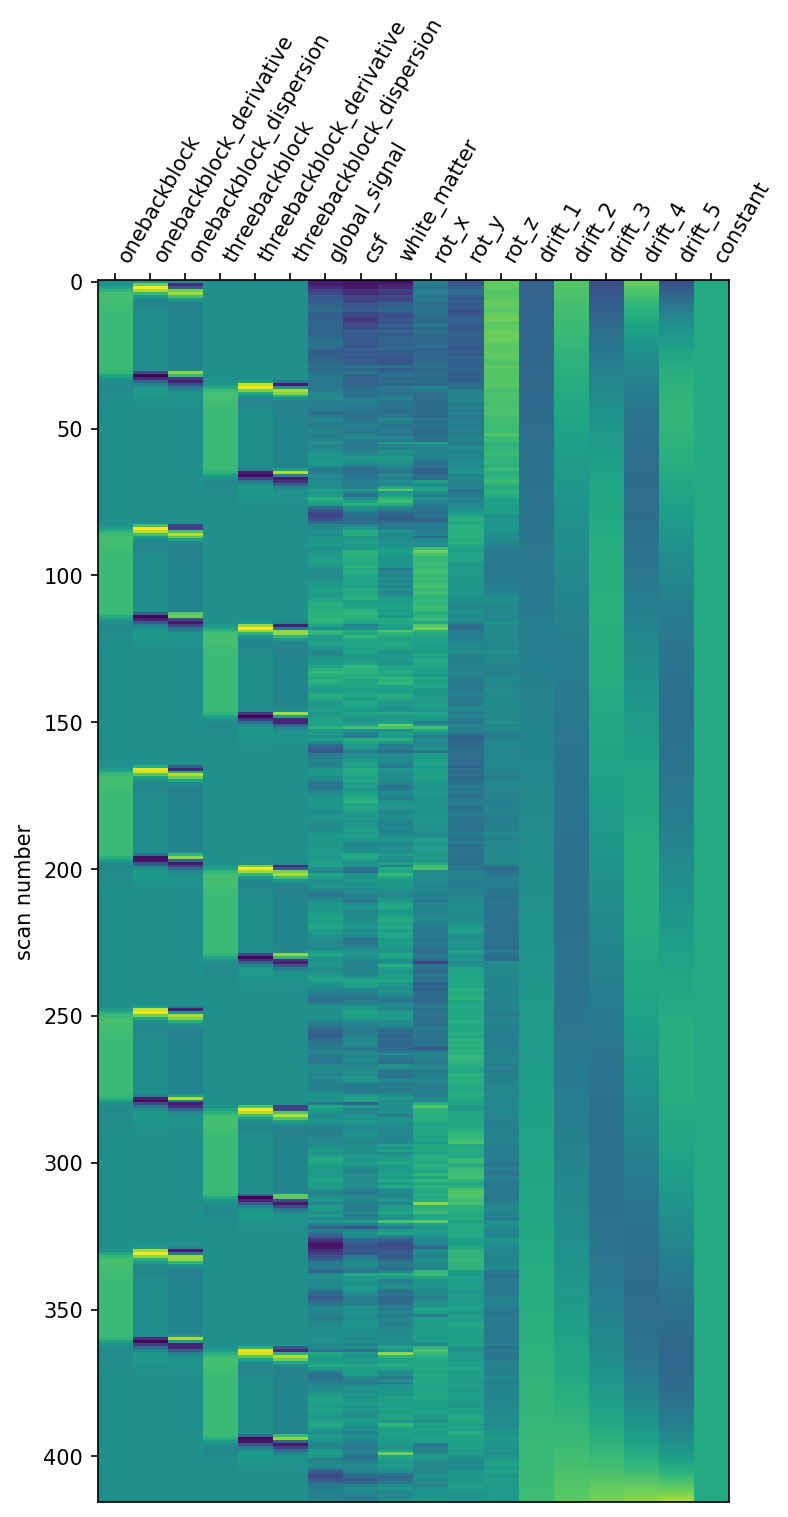

In [ ]:
from nilearn.plotting import plot_design_matrix

plt.rcParams['figure.dpi'] = 150
plt.show()
plot_design_matrix(dm_df)

In [41]:
from nilearn import plotting as nlp
def plot_dscalar(
    img,
    colorbar=True,
    # plot_abs=False,
    vmax=None,
    threshold=None,
    cmap='cold_hot',
    output_file=None,
):
    import matplotlib as mpl
    from matplotlib import pyplot as plt

    subcort, ltexture, rtexture = decompose_dscalar(img)
    fig = plt.figure(figsize=(11, 9))
    ax1 = plt.subplot2grid((3, 2), (0, 0), projection='3d')
    ax2 = plt.subplot2grid((3, 2), (0, 1), projection='3d')
    ax3 = plt.subplot2grid((3, 2), (1, 0), projection='3d')
    ax4 = plt.subplot2grid((3, 2), (1, 1), projection='3d')
    ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    # surf_fmt = 'data/conte69/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
    surf_fmt = '/scratch/ttan/ScanD_pipelines_scc/bin/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
    lsurf = nb.load(surf_fmt(hemi='L')).agg_data()
    rsurf = nb.load(surf_fmt(hemi='R')).agg_data()
    kwargs = {
        'threshold': None if threshold == 'auto' else threshold,
        'colorbar': False,
        # 'plot_abs': plot_abs,
        'cmap': cmap,
        'vmax': vmax,
    }
    nlp.plot_surf_stat_map(lsurf, ltexture, view='lateral', axes=ax1, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='medial', axes=ax2, **kwargs)
    nlp.plot_surf_stat_map(lsurf, ltexture, view='medial', axes=ax3, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='lateral', axes=ax4, **kwargs)
    nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5, **kwargs)
    if colorbar:
        data = img.get_fdata(dtype=np.float32)
        if vmax is None:
            vmax = max(-data.min(), data.max())
        norm = mpl.colors.Normalize(vmin=-vmax if data.min() < 0 else 0, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        fig.colorbar(sm, ax=fig.axes, location='right', aspect=50)
    if output_file:
        fig.savefig(output_file)
        plt.close(fig)

In [38]:
def decompose_dscalar(img):
    data = img.get_fdata(dtype=np.float32)
    ax = img.header.get_axis(1)
    vol = np.zeros(ax.volume_shape, dtype=np.float32)
    vox_indices = tuple(ax.voxel[ax.volume_mask].T)
    vol[vox_indices] = data[:, ax.volume_mask]
    subcort = nb.Nifti1Image(vol, ax.affine)

    surfs = {}
    for name, indices, brainmodel in ax.iter_structures():
        if not name.startswith('CIFTI_STRUCTURE_CORTEX_'):
            continue
        hemi = name.split('_')[3].lower()
        texture = np.zeros(brainmodel.vertex.max() + 1, dtype=np.float32)
        texture[brainmodel.vertex] = data[:, indices]
        surfs[hemi] = texture

    return subcort, surfs['left'], surfs['right']

In [39]:
from nipype.utils.filemanip import fname_presuffix, split_filename
import nibabel as nb
fname = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'
_, _, ext = split_filename(fname)

fdata = nb.load(fname)
fdata
subcort, ltexture, rtexture = decompose_dscalar(fdata)
vmax_r = np.percentile(rtexture, 99)
vmax_l = np.percentile(ltexture,99)
vmax = (vmax_r + vmax_l) / 2
vmax

np.float32(1.7428417)

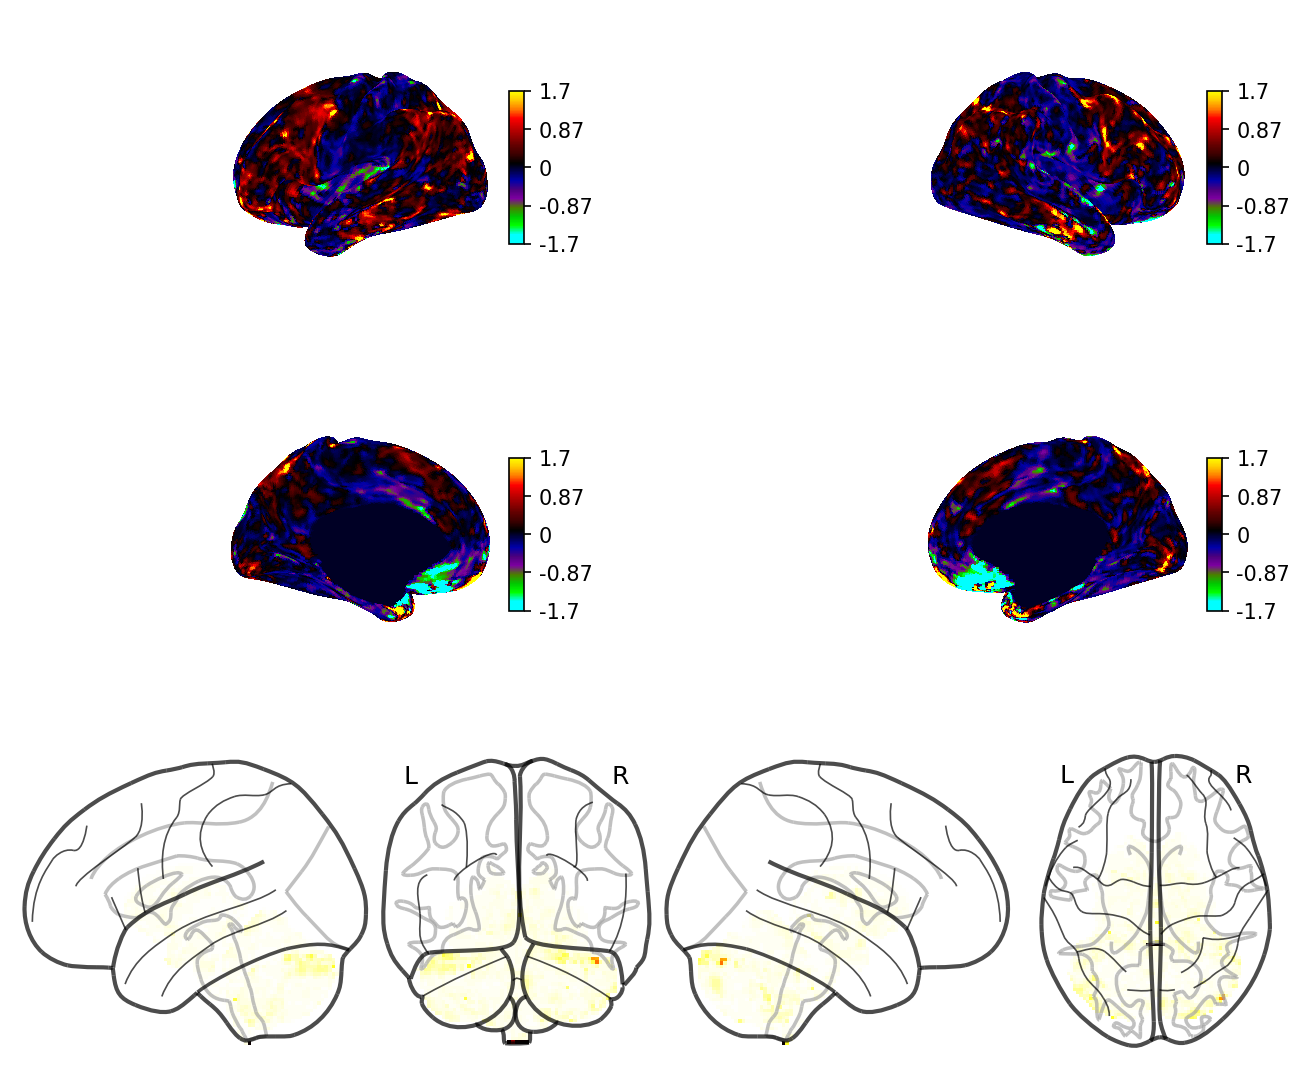

In [88]:
from nipype.utils.filemanip import fname_presuffix, split_filename
import nibabel as nb
fname = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'
_, _, ext = split_filename(fname)

fdata = nb.load(fname)
fdata
subcort, ltexture, rtexture = decompose_dscalar(fdata)
vmax_r = np.percentile(rtexture, 99)
vmax_l = np.percentile(ltexture,99)
vmax = (vmax_r + vmax_l) / 2
fig = plt.figure(figsize=(11, 9))
ax1 = plt.subplot2grid((3, 2), (0, 0), projection='3d')
ax2 = plt.subplot2grid((3, 2), (0, 1), projection='3d')
ax3 = plt.subplot2grid((3, 2), (1, 0), projection='3d')
ax4 = plt.subplot2grid((3, 2), (1, 1), projection='3d')
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
surf_fmt = '/scratch/ttan/ScanD_pipelines_scc/bin/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
lsurf = nb.load(surf_fmt(hemi='L')).agg_data()
rsurf = nb.load(surf_fmt(hemi='R')).agg_data()
# kwargs = {
#     'threshold': None if threshold == 'auto' else threshold,
#     'colorbar': False,
#     # 'plot_abs': plot_abs,
#     'cmap': cmap,
#     'vmax': vmax,
# }
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='roy_big_bl', view='lateral', axes=ax1, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='roy_big_bl', view='medial', axes=ax2, )
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='roy_big_bl', view='medial', axes=ax3, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='roy_big_bl', view='lateral', axes=ax4, )
nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5, )

In [76]:
rtexture

array([-0.15902643, -0.05637239, -0.2977429 , ...,  0.03738158,
        0.10820606,  0.23644692], shape=(32492,), dtype=float32)

In [75]:
ltexture

array([ 0.18558972,  0.01975936,  0.46639207, ...,  0.14628464,
       -0.03601536,  0.19561161], shape=(32492,), dtype=float32)

In [ ]:
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='bwr', view='lateral', axes=ax1, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='bwr', view='medial', axes=ax2, )
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='bwr', view='medial', axes=ax3, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='bwr', view='lateral', axes=ax4, )
nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5, )

In [81]:
import numpy as np
vmax = None
abs_data = np.abs(fdata.get_fdata(dtype=np.float32))
pctile99 = np.percentile(abs_data, 99.99)
if abs_data.max() - pctile99 > 10:
    vmax = pctile99
vmax

np.float32(17.495914)

In [79]:
vmax = np.percentile(rtexture, 99)
vmax

np.float32(1.8992103)

In [83]:
subcort

In [86]:
vmax = np.percentile(subcort.get_fdata(dtype=np.float32), 99)
vmax

np.float32(0.25542971)

In [ ]:
# from nipype.interfaces.base import traits
# threshold = traits.Enum('auto', None, traits.Float(), usedefault=True)
# vmax = traits.Float()
# colormap = traits.Str('bwr', usedefault=True)

In [50]:
### Fitlins

import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import plotting as nlp
from collections import namedtuple
from pkg_resources import resource_filename
from nipype.interfaces.base import (
    SimpleInterface,
    BaseInterfaceInputSpec,
    TraitedSpec,
    File,
    traits,
    isdefined,
)

from nipype.utils.filemanip import fname_presuffix, split_filename



In [30]:
class VisualizationInputSpec(BaseInterfaceInputSpec):
    data = File(mandatory=True, desc='Data file to visualize')
    image_type = traits.Enum('svg', 'png', mandatory=True)


In [31]:
class VisualizationOutputSpec(TraitedSpec):
    figure = File(desc='Visualization')

In [32]:
class Visualization(SimpleInterface):
    input_spec = VisualizationInputSpec
    output_spec = VisualizationOutputSpec

    def _run_interface(self, runtime):
        import matplotlib

        matplotlib.use('Agg')
        import seaborn as sns
        from matplotlib import pyplot as plt

        sns.set_style('white')
        plt.rcParams['svg.fonttype'] = 'none'
        plt.rcParams['image.interpolation'] = 'nearest'

        data = self._load_data(self.inputs.data)
        out_name = fname_presuffix(
            self.inputs.data,
            suffix='.' + self.inputs.image_type,
            newpath=runtime.cwd,
            use_ext=False,
        )
        self._visualize(data, out_name)
        self._results['figure'] = out_name
        return runtime

    def _load_data(self, fname):
        _, _, ext = split_filename(fname)
        if ext == '.tsv':
            return pd.read_table(fname, index_col=0)
        elif ext in ('.nii', '.nii.gz', '.gii'):
            return nb.load(fname)
        raise ValueError("Unknown file type!")

In [33]:
class GlassBrainPlotInputSpec(VisualizationInputSpec):
    threshold = traits.Enum('auto', None, traits.Float(), usedefault=True)
    vmax = traits.Float()
    colormap = traits.Str('bwr', usedefault=True)

In [70]:
class GlassBrainPlot(Visualization):
    input_spec = GlassBrainPlotInputSpec

    def _visualize(self, data, out_name):
        import numpy as np

        vmax = self.inputs.vmax
        if not isdefined(vmax):
            vmax = None
            abs_data = np.abs(data.get_fdata(dtype=np.float32))
            pctile99 = np.percentile(abs_data, 99.99)
            if abs_data.max() - pctile99 > 10:
                vmax = pctile99
        if isinstance(data, nb.Cifti2Image):
            plot_dscalar(
                data,
                vmax=vmax,
                threshold=self.inputs.threshold,
                cmap=self.inputs.colormap,
                output_file=out_name,
            )
        else:
            nlp.plot_glass_brain(
                data,
                colorbar=True,
                plot_abs=False,
                display_mode='lyrz',
                axes=None,
                vmax=vmax,
                threshold=self.inputs.threshold,
                cmap=self.inputs.colormap,
                output_file=out_name,
            )
            
def plot_dscalar(
    img,
    colorbar=True,
    # plot_abs=False,
    vmax=None,
    threshold=None,
    cmap='roy_big_bl',
    output_file=None,
):
    import matplotlib as mpl
    from matplotlib import pyplot as plt

    subcort, ltexture, rtexture = decompose_dscalar(img)
    fig = plt.figure(figsize=(11, 9))
    ax1 = plt.subplot2grid((3, 2), (0, 0), projection='3d')
    ax2 = plt.subplot2grid((3, 2), (0, 1), projection='3d')
    ax3 = plt.subplot2grid((3, 2), (1, 0), projection='3d')
    ax4 = plt.subplot2grid((3, 2), (1, 1), projection='3d')
    ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    surf_fmt = '/projects/ttan/SCanD_project/code/glm/templates/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
    lsurf = nb.load(surf_fmt(hemi='L')).agg_data()
    rsurf = nb.load(surf_fmt(hemi='R')).agg_data()
    kwargs = {
        'threshold': None if threshold == 'auto' else threshold,
        'colorbar': False,
        # 'plot_abs': plot_abs,
        'cmap': cmap,
        'vmax': vmax,
    }
    nlp.plot_surf_stat_map(lsurf, ltexture, view='lateral', axes=ax1, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='medial', axes=ax2, **kwargs)
    nlp.plot_surf_stat_map(lsurf, ltexture, view='medial', axes=ax3, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='lateral', axes=ax4, **kwargs)
    nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5)
    if colorbar:
        data = img.get_fdata(dtype=np.float32)
        if vmax is None:
            vmax = max(-data.min(), data.max())
        norm = mpl.colors.Normalize(vmin=-vmax if data.min() < 0 else 0, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        fig.colorbar(sm, ax=fig.axes, location='right', aspect=50)
    if output_file:
        fig.savefig(output_file)
        plt.close(fig)


def decompose_dscalar(img):
    data = img.get_fdata(dtype=np.float32)
    ax = img.header.get_axis(1)
    vol = np.zeros(ax.volume_shape, dtype=np.float32)
    vox_indices = tuple(ax.voxel[ax.volume_mask].T)
    vol[vox_indices] = data[:, ax.volume_mask]
    subcort = nb.Nifti1Image(vol, ax.affine)

    surfs = {}
    for name, indices, brainmodel in ax.iter_structures():
        if not name.startswith('CIFTI_STRUCTURE_CORTEX_'):
            continue
        hemi = name.split('_')[3].lower()
        texture = np.zeros(brainmodel.vertex.max() + 1, dtype=np.float32)
        texture[brainmodel.vertex] = data[:, indices]
        surfs[hemi] = texture

    return subcort, surfs['left'], surfs['right']

In [67]:
dscalar_viz = GlassBrainPlot()
dscalar_viz.inputs.data = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'
dscalar_viz.inputs.image_type = 'png'
dscalar_viz.inputs.vmax = 1.7428417
dscalar_viz.inputs.colormap = 'roy_big_bl'


In [68]:
dscalar_viz.inputs


colormap = roy_big_bl
data = /scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii
image_type = png
threshold = auto
vmax = 1.7428417

In [62]:
%matplotlib inline

In [71]:
dscalar_viz.run()

In [42]:
dscalar_viz.inputs


colormap = bwr
data = /scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii
image_type = png
threshold = auto
vmax = <undefined>

In [ ]:
import numpy as np
from nilearn.surface import SurfaceImage
from templateflow import api as tflow
from pathlib import Path
from nilearn.surface import load_surf_data

left_surf_32k = tflow.get('fsLR',suffix='midthickness', hemi='L', density='32k', extension='surf.gii')
right_surf_32k = tflow.get('fsLR',suffix='midthickness', hemi='R', density='32k', extension='surf.gii')

try:
    templateflow_dir = Path(os.getenv("TEMPLATEFLOW_HOME"))
    print(f"TEMPLATEFLOW_HOME is set to: {templateflow_dir}")
except KeyError:
    print("TEMPLATEFLOW_HOME is not set. Please set it first.")

mesh = {
    "left": templateflow_dir / "tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii",
    "right": templateflow_dir / "tpl-fsLR_den-32k_hemi-R_midthickness.surf.gii"
    # "volume": "/home/ttan/.cache/templateflow/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_res-02_T1w.nii.gz"
}


In [ ]:
lh_data = load_surf_data((imgs[0], mesh["left"]))

In [182]:
!pip install fitlins  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:0031m15.2 MB/s eta 0:00:01
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 19.6 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 21.9 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached nipype-1.9.2-py3-none-any.whl (3.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 11.5 MB/s eta 0:00:00
  Using cached looseversion-1.3.0-py2.py3-none-any.whl (8.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached etelemetry-0.3.1-py3-none-any.whl (6.4 kB)
  Using cached pydot-3.0.4-py3-none-any.whl (35 kB)
  Using cached prov-2.0.1-py3-none-any.whl (421 kB)
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from fitlins.interfaces import visualizations

dscalar_file = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'

# visualizations.Visualization()
# glass_brain = visualizations.GlassBrainPlot(image_type='png', data=dscalar_file)

AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [ ]:
os.path.exists('/home/ttan/.cache/templateflow/tpl-fsLR/tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii')

In [ ]:
# model.fit(imgs[0], design_matrices=dm)

In [ ]:
import pandas as pd
pd.set_option('display.max_row',550)
events_df_final

In [ ]:
layout = BIDSLayout(derivatives_dir,is_derivative=True,validate=False)

In [ ]:
# layout.add_derivatives(derivatives_dir)

In [ ]:
# layout

In [ ]:
sub029_files = layout.get(subject='CMHWM027',task='nbk',run='1',space='fsLR')

In [ ]:
sub029_files[0].get_entities()